# Machine Learning with Scikit-Learn

In [2]:
# Global imports and settings

# Matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.max_open_warning"] = -1

# Print options
import numpy as np
np.set_printoptions(precision=3)

# Slideshow
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {'width': 1440, 'height': 768, 'scroll': True, 'theme': 'simple'})

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

# Helper functions
def plot_surface(clf, X, y, 
                 xlim=(-10, 10), ylim=(-10, 10), n_steps=250, 
                 subplot=None, show=True):
    if subplot is None:
        fig = plt.figure()
    else:
        plt.subplot(*subplot)
        
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], n_steps), 
                         np.linspace(ylim[0], ylim[1], n_steps))
    
    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, alpha=0.8, cmap=plt.cm.RdBu_r)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    
    if show:
        plt.show()

In [41]:
# %%javascript
# Reveal.addEventListener("slidechanged", function(event){ window.location.hash = "header"; });

## Scikit-Learn

* Machine learning library written in __Python__
* __Simple and efficient__, for both experts and non-experts
* Classical, __well-established machine learning algorithms__
* Shipped with <a href="http://scikit-learn.org/dev/documentation.html">documentation</a> and <a href="http://scikit-learn.org/dev/auto_examples/index.html">examples</a>
* Community-driven

## Algorithms
See the [Reference](http://scikit-learn.org/dev/modules/classes.html)

__Supervised learning:__

* Linear models (Ridge, Lasso, Elastic Net, ...)
* Support Vector Machines
* Tree-based methods (Classification/Regression Trees, Random Forests,...)
* Nearest neighbors
* Neural networks 
* Gaussian Processes
* Feature selection

__Unsupervised learning:__

* Clustering (KMeans, ...)
* Matric Decomposition (PCA, ...)
* Manifold Learning (Embeddings)
* Density estimation
* Outlier detection

__Model selection and evaluation:__

* Cross-validation
* Grid-search
* Lots of metrics

# Classification

## Data 

- Input data = Numpy arrays or Scipy sparse matrices ;
- Algorithms are expressed using high-level operations defined on matrices or vectors (similar to MATLAB) ;
    - Leverage efficient low-leverage implementations ;
    - Keep code short and readable. 

In [4]:
# Generate data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=20, random_state=123)
labels = ["b", "r"]
y = np.take(labels, (y < 10)) # Relabels numeric values to b,r
print(X)
print(y[:5])

[[-6.453 -8.764]
 [ 0.29   0.147]
 [-5.184 -1.253]
 ..., 
 [-0.231 -1.608]
 [-0.603  6.873]
 [ 2.284  4.874]]
['r' 'r' 'b' 'r' 'b']


In [5]:
# X is a 2 dimensional array, with 1000 rows and 2 columns
print(X.shape)
 
# y is a vector of 1000 elements
print(y.shape)

(1000, 2)
(1000,)


In [6]:
# Rows and columns can be accessed with lists, slices or masks
print(X[[1, 2, 3]])     # rows 1, 2 and 3
print(X[:5])            # 5 first rows
print(X[500:510, 0])    # values from row 500 to row 510 at column 0
print(X[y == "b"][:5])  # 5 first rows for which y is "b"

[[ 0.29   0.147]
 [-5.184 -1.253]
 [-4.714  3.674]]
[[-6.453 -8.764]
 [ 0.29   0.147]
 [-5.184 -1.253]
 [-4.714  3.674]
 [ 4.516 -2.881]]
[-4.438 -2.46   4.331 -7.921  1.57   0.565  4.996  4.758 -1.604  1.101]
[[-5.184 -1.253]
 [ 4.516 -2.881]
 [ 1.708  2.624]
 [-0.526  8.96 ]
 [-1.076  9.787]]


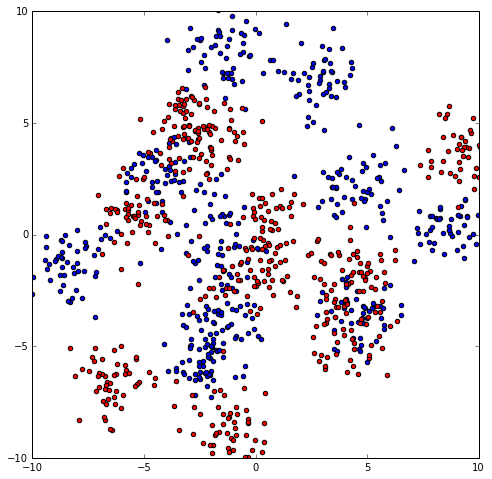

In [7]:
# Plot
plt.figure()
for label in labels:
    mask = (y == label)
    plt.scatter(X[mask, 0], X[mask, 1], c=label)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

## Loading external data

- Numpy provides some [simple tools](https://docs.scipy.org/doc/numpy/reference/routines.io.html) for loading data from files (CSV, binary, etc);

- For structured data, Pandas provides more [advanced tools](http://pandas.pydata.org/pandas-docs/stable/io.html) (CSV, JSON, Excel, HDF5, SQL, etc);

- For ROOT files, ``root_numpy`` provides loaders and converters to Numpy arrays.

## Loading data from OpenML
* OpenML: An open machine learning collaboration platform with many datasets, models, experiments
* Register on [openml.org](http://www.openml.org), go to your profile to find API your key
    - Store it in a file (e.g. `.openml/apikey.txt`)
* Browse openml.org for interesting datasets, download by their ID

In [8]:
from openml.apiconnector import APIConnector
import pandas as pd
import os

# OpenML requires an API key, you can find it in your profile after you register on OpenML.org
# It is good practice to store your API key in a file (and not in the code)
# Create a folder '.openml' in your homedir and add a 'apikey.txt' file containing only your key.
# Use a simple text editor (e.g. Notepad, vim, pico,...) to do this
home_dir = os.path.expanduser("~")
openml_dir = os.path.join(home_dir, ".openml")
cache_dir = os.path.join(openml_dir, "cache")
with open(os.path.join(openml_dir, "apikey.txt"), 'r') as fh:
	key = fh.readline().rstrip('\n')
    
# If the above doesn't work, you can put your API key in the code
# key = "123456789qwertyuiop"
openml = APIConnector(cache_directory=cache_dir, apikey=key)

### List ALL the datasets

In [9]:
datasets = openml.get_dataset_list()

data = pd.DataFrame(datasets)
print("First 10 of %s datasets..." % len(datasets))
print(data[:10][['did','name','NumberOfInstances','NumberOfFeatures']])

First 10 of 2420 datasets...
   did             name  NumberOfInstances  NumberOfFeatures
0    1           anneal                898                39
1    2           anneal                898                39
2    3         kr-vs-kp               3196                37
3    4            labor                 57                17
4    5       arrhythmia                452               280
5    6           letter              20000                17
6    7        audiology                226                70
7    8  liver-disorders                345                 7
8    9            autos                205                26
9   10            lymph                148                19


Subset based on any property

In [10]:
bin_data = data.loc[data['NumberOfClasses'] == 2]
print("First 10 of %s datasets..." % len(bin_data))
print(bin_data[:10][['did','name', 'NumberOfInstances','NumberOfFeatures']])

First 10 of 591 datasets...
    did           name  NumberOfInstances  NumberOfFeatures
2     3       kr-vs-kp               3196                37
3     4          labor                 57                17
12   13  breast-cancer                286                10
14   15       breast-w                699                10
21   24       mushroom               8124                23
22   25          colic                368                28
24   27          colic                368                23
26   29       credit-a                690                16
28   31       credit-g               1000                21
33   37       diabetes                768                 9


In [11]:
big_data = data.loc[data['NumberOfInstances'] > 60000]
big_data = big_data.sort_values(by='NumberOfInstances', ascending=True)
print("First 10 of %s datasets..." % len(big_data))
print(big_data[:10][['did','name', 'NumberOfInstances']])

First 10 of 222 datasets...
       did                          name  NumberOfInstances
1289  1588                           w8a              64700
2397  4533  KEGGMetabolicReactionNetwork              65554
1292  1591                     connect-4              67557
413    554                     mnist_784              70000
1280  1578                      real-sim              72309
1050  1213                       BNG(mv)              78732
2396  4532                         higgs              98050
1294  1593       SensIT-Vehicle-Combined              98528
1067  1242                   vehicleNorm              98528
240    357                vehicle_sensIT              98528


Download a specific dataset. This is done based on the dataset ID (called 'did' in the table above).

In [12]:
dataset = openml.download_dataset(61)

print("This is dataset '%s', the target feature is called '%s'" % (dataset.name, dataset.default_target_attribute))
print("URL: %s" % dataset.url)
print(dataset.description[:500])

This is dataset 'iris', the target feature is called 'class'
URL: http://www.openml.org/data/download/61/dataset_61_iris.arff
**Author**: R.A. Fisher  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Iris) - 1936 - Donated by Michael Marshall  
**Please cite**:   

**Iris Plants Database**  
This is perhaps the best known database to be found in the pattern recognition literature.  Fisher's paper is a classic in the field and is referenced frequently to this day.  (See Duda & Hart, for example.)  The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  One class 


Get the actual data

In [13]:
X, y = dataset.get_dataset(target=dataset.default_target_attribute)
print(X[:10])
print(y[:10])

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]
 [ 5.4  3.9  1.7  0.4]
 [ 4.6  3.4  1.4  0.3]
 [ 5.   3.4  1.5  0.2]
 [ 4.4  2.9  1.4  0.2]
 [ 4.9  3.1  1.5  0.1]]
[0 0 0 0 0 0 0 0 0 0]


Or in a pandas dataframe:

In [14]:
X, y, attribute_names = dataset.get_dataset(target=dataset.default_target_attribute, return_attribute_names=True)
iris = pd.DataFrame(X, columns=attribute_names)
iris['class'] = y
print(iris[:10])

   sepallength  sepalwidth  petallength  petalwidth  class
0          5.1         3.5          1.4         0.2      0
1          4.9         3.0          1.4         0.2      0
2          4.7         3.2          1.3         0.2      0
3          4.6         3.1          1.5         0.2      0
4          5.0         3.6          1.4         0.2      0
5          5.4         3.9          1.7         0.4      0
6          4.6         3.4          1.4         0.3      0
7          5.0         3.4          1.5         0.2      0
8          4.4         2.9          1.4         0.2      0
9          4.9         3.1          1.5         0.1      0


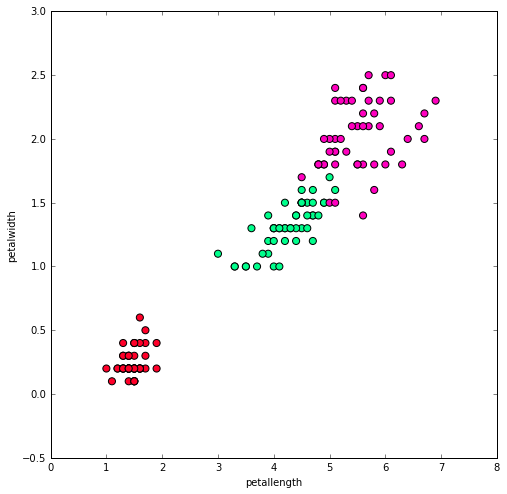

In [15]:
iris.plot(kind='scatter', x='petallength', y='petalwidth', c='class', colormap='gist_rainbow', colorbar=False, s=50)

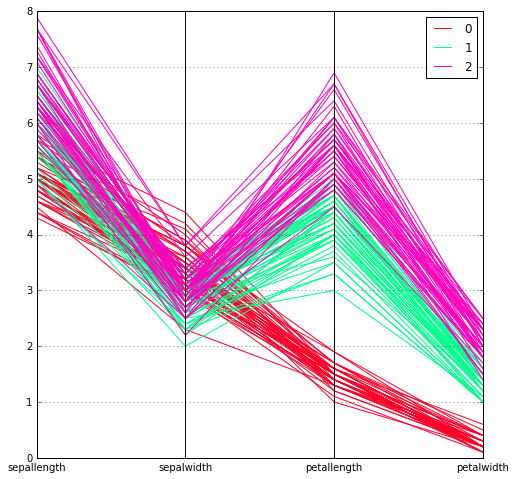

In [16]:
from pandas.tools.plotting import parallel_coordinates
plt.figure()
parallel_coordinates(iris, 'class', colormap='gist_rainbow')

## A simple and unified API

All learning algorithms in scikit-learn share a uniform and limited API consisting of complementary interfaces:

- an `estimator` interface for building and fitting models;
- a `predictor` interface for making predictions;
- a `transformer` interface for converting data.

You can __swap or plug algorithms__ 

### Estimators

In [17]:
class Estimator(object):
    def fit(self, X, y=None):
        """Fits estimator to data."""
        # set state of ``self``
        return self

In [18]:
# Back to blobs
X, y = make_blobs(n_samples=1000, centers=20, random_state=123)
labels = ["b", "r"]
y = np.take(labels, (y < 10)) # Relabels numeric values to b,r

# Import the decision tree class
from sklearn.tree import DecisionTreeClassifier  # Change this to try 
                                                 # something else 

# Set hyper-parameters, for controlling algorithm
clf = DecisionTreeClassifier()


# Learn a model from training data
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

### Predictors

In [19]:
# Make predictions  
print(clf.predict(X[:5])) 

['r' 'r' 'b' 'r' 'b']


In [20]:
# Compute (approximate) class probabilities
print(clf.predict_proba(X[:5]))

[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]]


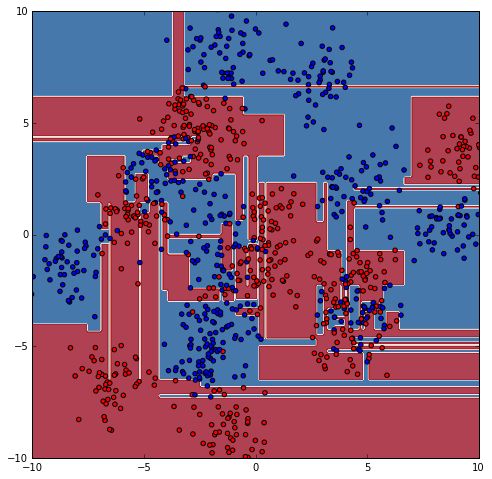

In [21]:
plot_surface(clf, X, y)

In [22]:
# Visualize the tree.
from sklearn import tree
tree.export_graphviz(clf, out_file='tree.dot') 

# pydot is not yet ported to Python 3. Bummer...
# import pydot 

# We need to open the generated .dot file outside of Python (using GraphViz)

<img src="files/tree.png">

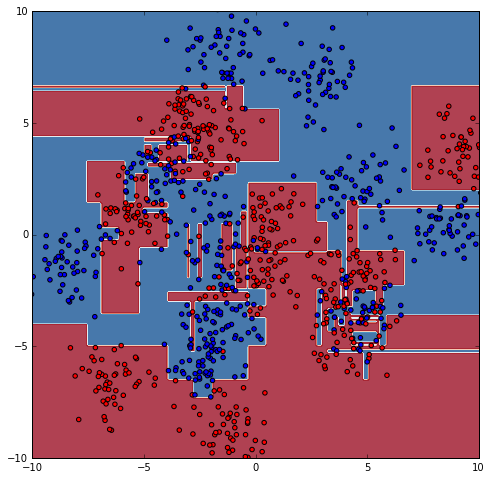

In [23]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=None) # information gain
clf.fit(X, y)
plot_surface(clf, X, y)

## Classifier zoo

### K-nearest neighbours

Idea: Make prediction based on target class of k nearest neighbors (vote)

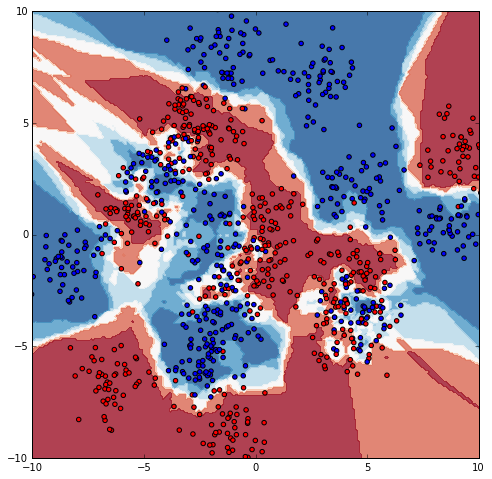

In [24]:
from sklearn.neighbors import KNeighborsClassifier
# Set hyper-parameters, for controlling algorithm
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X, y)
plot_surface(clf, X, y)

### Random Forests

Idea: Build several decision trees with controlled randomness and average their decisions.

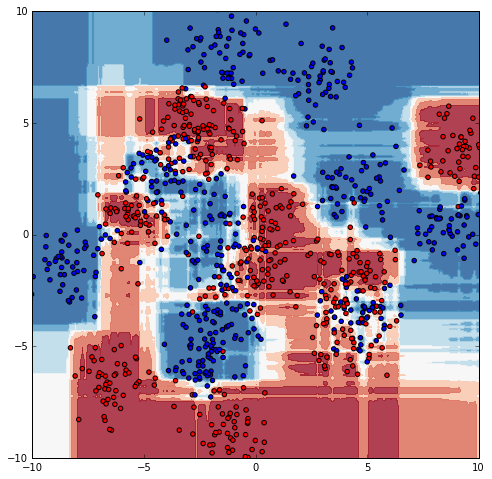

In [25]:
from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X, y)
plot_surface(clf, X, y)

### Support vector machines

Idea: Find the hyperplane which has the largest distance to the nearest training points of any class.

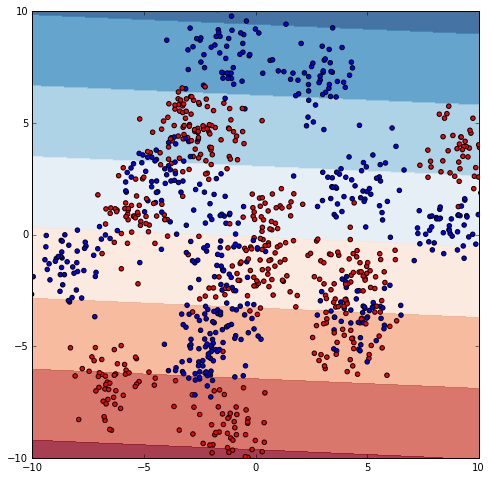

In [26]:
from sklearn.svm import SVC
clf = SVC(kernel="linear")  # try kernel="rbf" instead
clf.fit(X, y)
plot_surface(clf, X, y)

# Model evaluation and selection
Meant as demonstration. Theory given in next lecture.

## Training error

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
clf = DecisionTreeClassifier()
clf.fit(X, y)
print("Training error =", zero_one_loss(y, clf.predict(X)))

Training error = 0.0


## Test error

Issue: the training error is a __biased__ estimate of the generalization error.

Solution: Divide data into two disjoint parts called training and test sets (usually using 70% for training and 30% for test).
- Use the training set for fitting the model;
- Use the test set for evaluation only, thereby yielding an unbiased estimate.
- __The same data should not be used both for training and evaluation.__

In [28]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print("Training error =", zero_one_loss(y_train, clf.predict(X_train)))
print("Test error =", zero_one_loss(y_test, clf.predict(X_test)))

Training error = 0.0
Test error = 0.2


## Cross-validation

Issue: 
- When data is small, training on 70% of the data may lead to a model that is significantly different from a model that would have been learned on the entire set. 
- Yet, increasing the size of the training set (resp. decreasing the size of the test set), might lead to an inaccurate estimate of the generalization error. 

Solution: K-Fold cross-validation. 
- Split data into K small disjoint folds. 
- Train on K-1 folds, evaluate the test error one the held-out fold.
- Repeat for all combinations and average the K estimates of the generalization error.

In [29]:
from sklearn.cross_validation import KFold

scores = []

for train, test in KFold(n=len(X), n_folds=5, random_state=42):
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    clf = DecisionTreeClassifier().fit(X_train, y_train)
    scores.append(zero_one_loss(y_test, clf.predict(X_test)))

print("CV error = %f +-%f" % (np.mean(scores), np.std(scores)))

CV error = 0.180000 +-0.011832


In [30]:
# Shortcut
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(DecisionTreeClassifier(), X, y, 
                         cv=KFold(n=len(X), n_folds=5, random_state=42), 
                         scoring="accuracy")
print("CV error = %f +-%f" % (1. - np.mean(scores), np.std(scores)))

CV error = 0.187000 +-0.016000


## Metrics

### Default score

Estimators come with a built-in default evaluation score
* Accuracy for classification 
* R2 score for regression

In [31]:
y_train = (y_train == "r")
y_test = (y_test == "r")
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train) 
print("Default score =", clf.score(X_test, y_test))

Default score = 0.84


### Accuracy

Definition: The accuracy is the proportion of correct predictions.

In [32]:
from sklearn.metrics import accuracy_score
print("Accuracy =", accuracy_score(y_test, clf.predict(X_test)))

Accuracy = 0.84


### Precision, recall and F-measure

$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$
$$F = \frac{2 * Precision * Recall}{Precision + Recall}$$

In [33]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
print("Precision =", precision_score(y_test, clf.predict(X_test)))
print("Recall =", recall_score(y_test, clf.predict(X_test)))
print("F =", fbeta_score(y_test, clf.predict(X_test), beta=1))

Precision = 0.811881188119
Recall = 0.863157894737
F = 0.836734693878


### ROC AUC

Definition: Area under the curve of the false positive rate (FPR) against the true positive rate (TPR) as the decision threshold of the classifier is varied.

ROC AUC = 0.92977443609


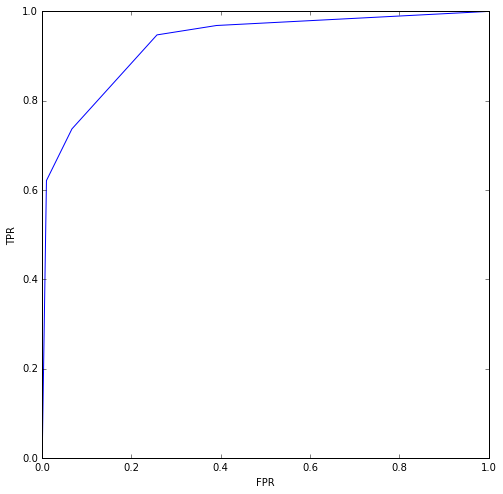

In [34]:
from sklearn.metrics import get_scorer
roc_auc_scorer = get_scorer("roc_auc")
print("ROC AUC =", roc_auc_scorer(clf, X_test, y_test))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### Confusion matrix

Definition: number of samples of class $i$ predicted as class $j$.

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, clf.predict(X_test))

array([[86, 19],
       [13, 82]])

# Transformers, pipelines and feature unions

## Transformers

- Classification (or regression) is often only one or the last step of a long and complicated process;
- In most cases, input data needs to be cleaned, massaged or extended before being fed to a learning algorithm;
- For this purpose, Scikit-Learn provides the ``transformer`` API.

In [36]:
class Transformer(object):    
    def fit(self, X, y=None):
        """Fits estimator to data."""
        # set state of ``self``
        return self
    
    def transform(self, X):
        """Transform X into Xt."""
        # transform X in some way to produce Xt
        return Xt
    
    # Shortcut
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        Xt = self.transform(X)
        return Xt

## Pipelines

Transformers can be chained in sequence to form a pipeline.

In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

# Get more complex data
dataset = openml.download_dataset(337)
X, y = dataset.get_dataset(target=dataset.default_target_attribute)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Chain transformers + a classifier to build a new classifier
clf = make_pipeline(SelectKBest(score_func=f_classif, k=44), 
                    RandomForestClassifier())
clf.fit(X_train, y_train)
print(clf.predict_proba(X_test)[:5])

[[ 0.   1. ]
 [ 0.2  0.8]
 [ 0.3  0.7]
 [ 0.   1. ]
 [ 0.   1. ]]


## Optimizing parameters
Search for the best hyperparameter settings

In [38]:
# Hyper-parameters can be accessed using step names
print("K =", clf.get_params()["selectkbest__k"])

K = 44


In [39]:
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(clf, 
                    param_grid={"selectkbest__k": [1, 10, 20, 30, 40],
                                "randomforestclassifier__max_features": [0.1, 0.25, 0.5]})
grid.fit(X_train, y_train)

print("Best params =", grid.best_params_)

Best params = {'selectkbest__k': 40, 'randomforestclassifier__max_features': 0.5}


# Summary

- Scikit-Learn provides essential tools for machine learning. 
- It is more than training classifiers!
- It integrates within a larger Python scientific ecosystem.
- Try it for yourself!

questions?

## Acknowledgements
Based on a tutorial by Gilles Loupe and sci-kit learn documentation